In [9]:
import pandas as pd

# Load your Parquet file
file_path = "../data/curated/map_features.parquet"
df = pd.read_parquet(file_path)

# Check the first few rows to ensure it's loaded correctly
print(df.head())

#property_types = df['property_type'].unique()

# Print the distinct property types
#print(property_types)

                                              name postcode   latitude  \
0         10/668 Bourke Street, Melbourne VIC 3000     3000 -37.816589   
1  1001/20-26 Coromandel Place, Melbourne VIC 3000     3000 -37.813044   
2     1001/23 Mackenzie Street, Melbourne VIC 3000     3000 -37.807481   
3      1003/118 Russell Street, Melbourne VIC 3000     3000 -37.813500   
4      1003/220 Spencer Street, Melbourne VIC 3000     3000 -37.815695   

    longitude  distance_to_closest_school_km  distance_to_cbd  \
0  144.954206                          0.959            1.399   
1  144.969255                          1.096            1.299   
2  144.967331                          0.464            1.062   
3  144.969088                          1.024            1.226   
4  144.952913                          1.197            1.638   

             property_type beds   cost  House  flat  
0  Apartment / Unit / Flat    1  560.0  False  True  
1  Apartment / Unit / Flat    2  530.0  False  True  
2 

In [10]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("Add Column from One Parquet to Another").getOrCreate()

# Load the two Parquet files
file1_path = "../data/raw/distances.parquet"
file2_path = "../data/raw/property_data.parquet"

df1 = spark.read.parquet(file1_path)
df2 = spark.read.parquet(file2_path)

#df2.show()

df2_selected = df2.select("name", "cost_text", "property_type", "beds" )

# Join the two DataFrames on the key (e.g., 'id')
df_merged = df1.join(df2_selected, on="name", how="left")  # Use appropriate join type (e.g., 'inner', 'left')

# Remove duplicates based on 'postcode' and 'name' columns
df_merged = df_merged.dropDuplicates(['postcode', 'name'])
df = df_merged
df = df.withColumn("cost", F.regexp_extract("cost_text", r"(\d+\.?\d*)", 1).cast("double"))
df_cleaned = df.dropna(subset=["cost"])
df_merged = df_cleaned
df_merged = df_merged.drop("cost_text")


df_merged = df_merged.withColumn(
    # Properties priced per week
    'House',
    F.when(F.lower(F.col('property_type')).contains('house'), True).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'flat',
    F.when(F.lower(F.col('property_type')).contains('flat') \
        | F.lower(F.col('property_type')).contains('apartment'), True ).otherwise(False)
)

df_merged.show()

# Save the merged DataFrame to a new Parquet file
output_file_path = "../data/curated/map_features.parquet"
df_merged.write.mode("overwrite").parquet(output_file_path)

+--------------------+--------+------------------+-----------+-----------------------------+---------------+--------------------+----+------+-----+-----+
|                name|postcode|          latitude|  longitude|distance_to_closest_school_km|distance_to_cbd|       property_type|beds|  cost|House| flat|
+--------------------+--------+------------------+-----------+-----------------------------+---------------+--------------------+----+------+-----+-----+
|10/668 Bourke Str...|    3000|       -37.8165887|144.9542063|                        0.959|          1.399|Apartment / Unit ...|   1| 560.0|false| true|
|1001/20-26 Coroma...|    3000|       -37.8130438|144.9692553|                        1.096|          1.299|Apartment / Unit ...|   2| 530.0|false| true|
|1001/23 Mackenzie...|    3000|       -37.8074807|144.9673314|                        0.464|          1.062|Apartment / Unit ...|   1| 530.0|false| true|
|1003/118 Russell ...|    3000|       -37.8134998|144.9690884|              

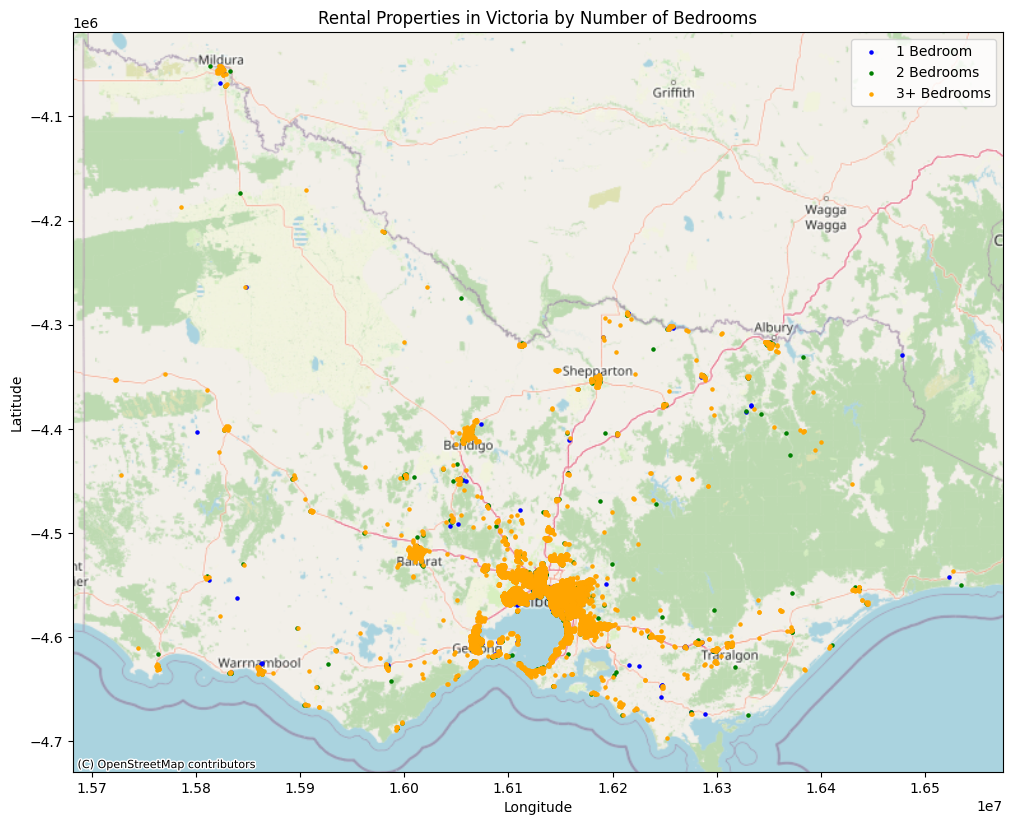

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles


df = pd.read_parquet('../data/curated/map_features.parquet/')


df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 10))

# Define color for each room category
colors = {1: 'blue', 2: 'green', 3: 'orange'}

# Plot properties with 1 room in blue
gdf[gdf['beds'] == 1].plot(ax=ax, marker='o', color=colors[1], markersize=5, label='1 Bedroom')

# Plot properties with 2 rooms in green
gdf[gdf['beds'] == 2].plot(ax=ax, marker='o', color=colors[2], markersize=5, label='2 Bedrooms')

# Plot properties with 3 or more rooms in orange
gdf[gdf['beds'] >= 3].plot(ax=ax, marker='o', color=colors[3], markersize=5, label='3+ Bedrooms')

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


plt.title('Rental Properties in Victoria by Number of Bedrooms')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the plot to a PNG file (optional)
# output_image_path = "../data/plots/rental_properties_by_rooms_map.png"
# plt.savefig(output_image_path, dpi=300)
# print(f"Map saved as PNG: {output_image_path}")

# Display the plot
plt.show()

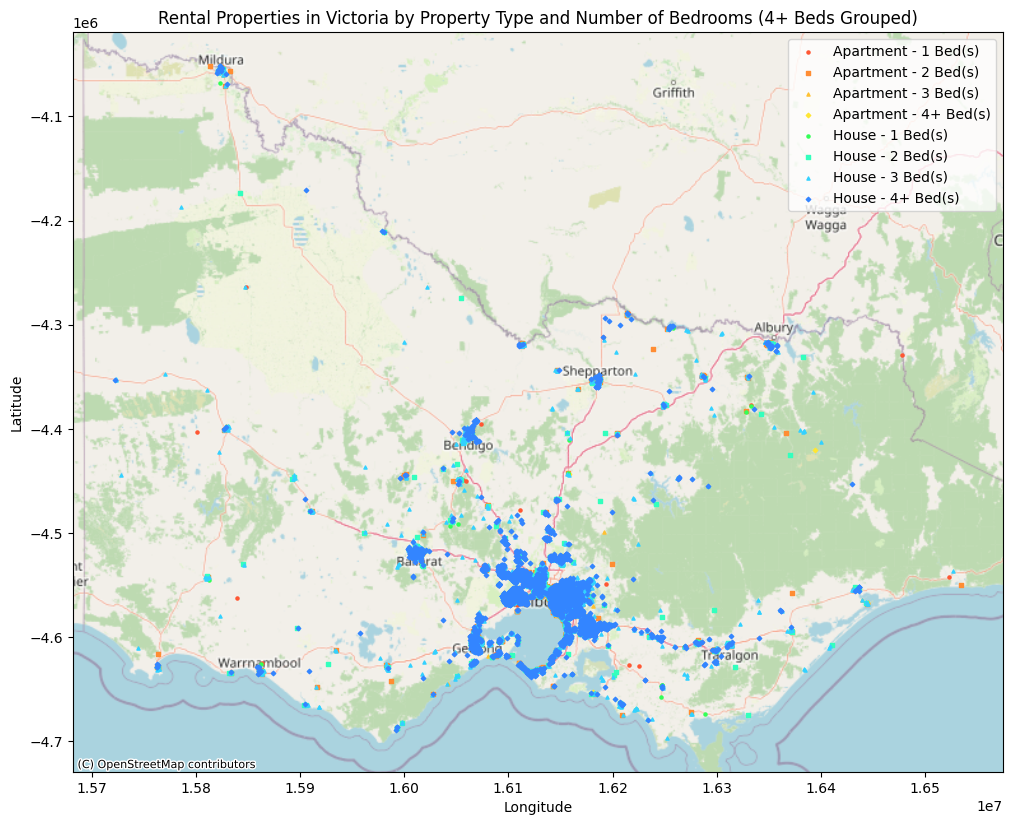

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles
import numpy as np

# Load the properties data (replace with your file)
df = pd.read_parquet('../data/curated/map_features.parquet')

# Convert 'beds' to numeric and filter out properties with 0 beds
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df = df[df['beds'] > 0]  # Remove properties with 0 beds

# Generalize beds to 4+ for bed counts greater than 4
df['beds_grouped'] = df['beds'].apply(lambda x: '4+' if x >= 4 else x)

# Generalize property types into 'Apartments' and 'Houses'
apartment_keywords = ['Apartment', 'New Apartments', 'Flat']
df['property_type_grouped'] = df['property_type'].apply(lambda x: 'Apartment' if any(keyword in x for keyword in apartment_keywords) else 'House')

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857), which is required for most web tile services
gdf = gdf.to_crs(epsg=3857)

# Define unique colors for each combination of property type and bed count
color_map = {
    ('Apartment', 1): '#FF5733',  # Red for 1-bed apartments
    ('Apartment', 2): '#FF8D33',  # Orange for 2-bed apartments
    ('Apartment', 3): '#FFC133',  # Yellow for 3-bed apartments
    ('Apartment', '4+'): '#FFE633',  # Light Yellow for 4+ bed apartments
    ('House', 1): '#33FF57',  # Green for 1-bed houses
    ('House', 2): '#33FFBD',  # Cyan for 2-bed houses
    ('House', 3): '#33D1FF',  # Blue for 3-bed houses
    ('House', '4+'): '#3385FF'  # Dark Blue for 4+ bed houses
}

# Create a list of marker symbols for beds
marker_symbols = {1: 'o', 2: 's', 3: '^', '4+': 'D'}

# Plot the properties on the map
fig, ax = plt.subplots(figsize=(12, 10))

# Loop through each unique property type and bed group
for (property_type, bed_type), color in color_map.items():
    gdf_filtered = gdf[(gdf['property_type_grouped'] == property_type) & (gdf['beds_grouped'] == bed_type)]
    
    # Only plot if there are properties with the current property type and bed type
    if not gdf_filtered.empty:
        marker_symbol = marker_symbols[bed_type]  # Assign a unique marker for each bed type
        
        gdf_filtered.plot(
            ax=ax,
            marker=marker_symbol,
            color=color,
            markersize=5,
            label=f"{property_type} - {bed_type} Bed(s)"
        )

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title, labels, and legend
plt.title('Rental Properties in Victoria by Property Type and Number of Bedrooms (4+ Beds Grouped)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()


In [13]:
df = spark.read.parquet('../data/landing/combined_data_with_geolocation.parquet', header=True, inferSchema=True)
#df.show()

df = df.withColumnRenamed("School_Count", "Number of Schools")
df = df.withColumnRenamed("groceries_Count", "Number of Groceries")
df = df.withColumnRenamed("hc_Count", "Number of Healthcare Services")
df = df.withColumnRenamed("Postcode", "postcode")
df = df.withColumnRenamed("Postcode_Name", "suburbs")
df
# Convert Spark DataFrame to Pandas for plotting
df_pandas = df.toPandas()
print(df)

DataFrame[postcode: string, Number of Schools: bigint, Number of Groceries: bigint, Number of Healthcare Services: bigint, Latitude: float, Longitude: float, suburbs: string]


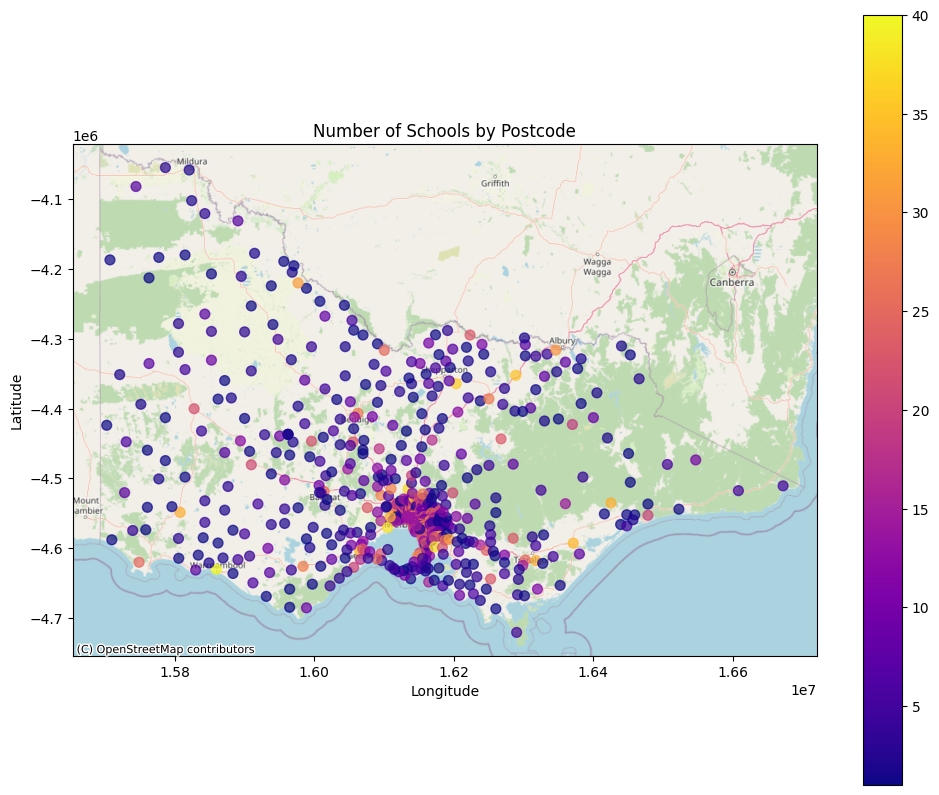

<Figure size 640x480 with 0 Axes>

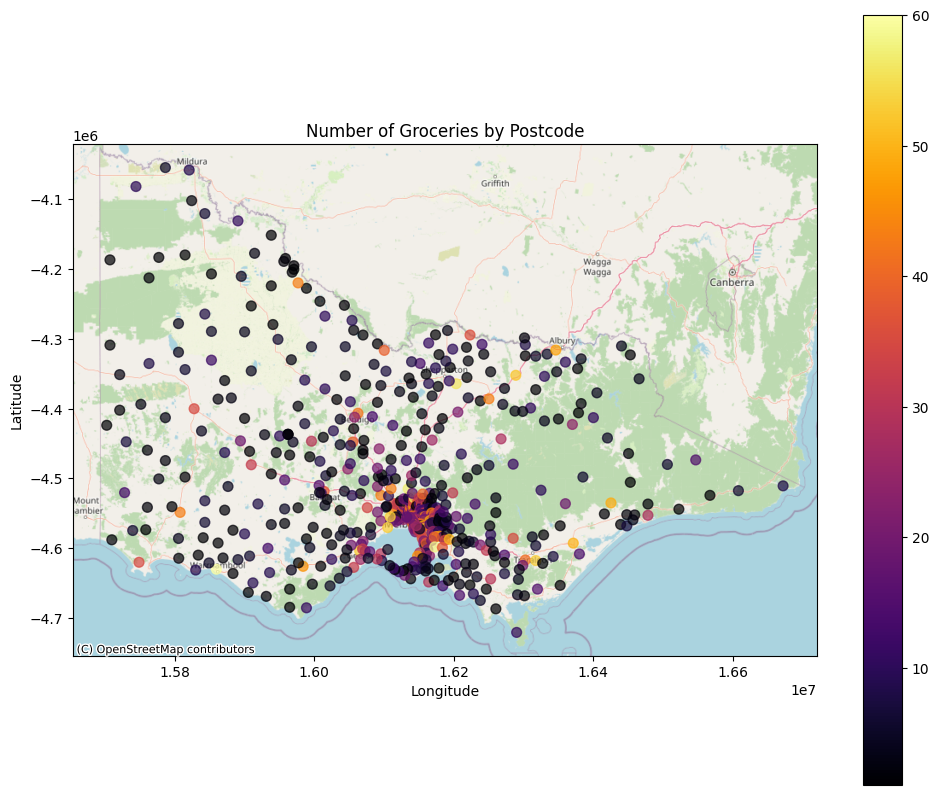

<Figure size 640x480 with 0 Axes>

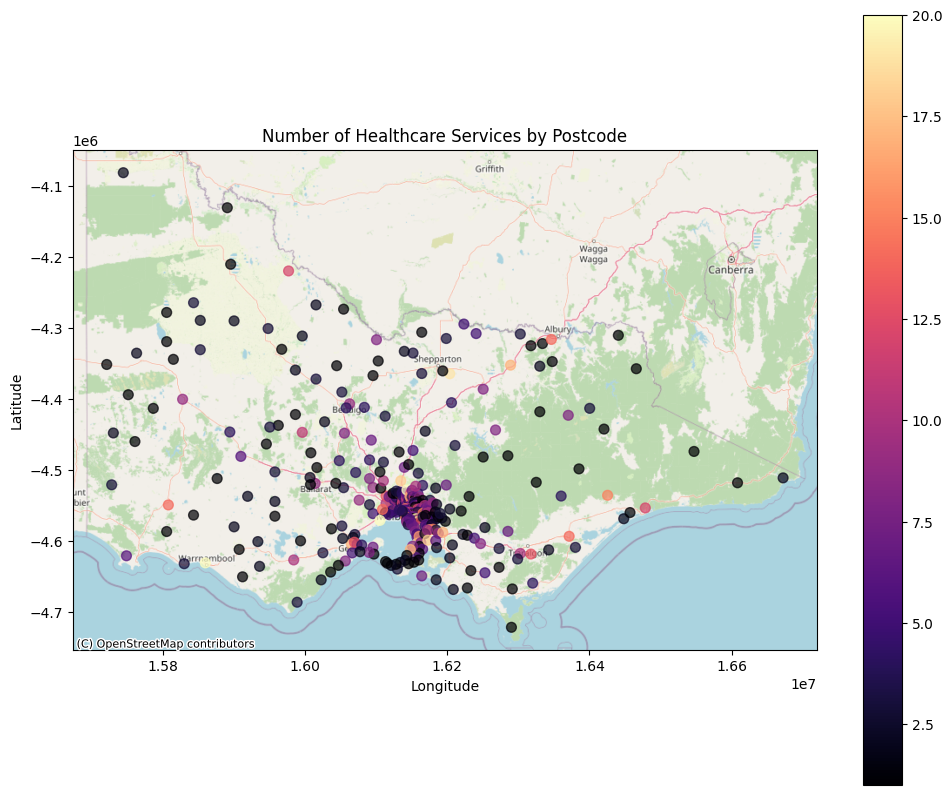

<Figure size 640x480 with 0 Axes>

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert the Pandas DataFrame to a GeoDataFrame using longitude and latitude
gdf = gpd.GeoDataFrame(df_pandas, geometry=gpd.points_from_xy(df_pandas['Longitude'], df_pandas['Latitude']))

# Set the CRS to EPSG:4326 (WGS 84, commonly used for geographic coordinates)
gdf.set_crs(epsg=4326, inplace=True)

# Reproject to Web Mercator (EPSG:3857) for plotting on a basemap
gdf = gdf.to_crs(epsg=3857)

# Plotting the number of schools
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Number of Schools', cmap='plasma', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Number of Schools by Postcode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Save the plot to a file
output_image_path = "../data/plots/schools.png"  
plt.savefig(output_image_path, dpi=300) 

# Plotting the number of groceries
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Number of Groceries', cmap='inferno', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Number of Groceries by Postcode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Save the plot to a file
output_image_path = "../data/plots/groceries.png"  
plt.savefig(output_image_path, dpi=300) 

# Plotting the number of healthcare services 
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Number of Healthcare Services', cmap='magma', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Number of Healthcare Services by Postcode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Save the plot to a file
output_image_path = "../data/plots/healthcare.png"  
plt.savefig(output_image_path, dpi=300) 


In [15]:
print(df.columns)


['postcode', 'Number of Schools', 'Number of Groceries', 'Number of Healthcare Services', 'Latitude', 'Longitude', 'suburbs']


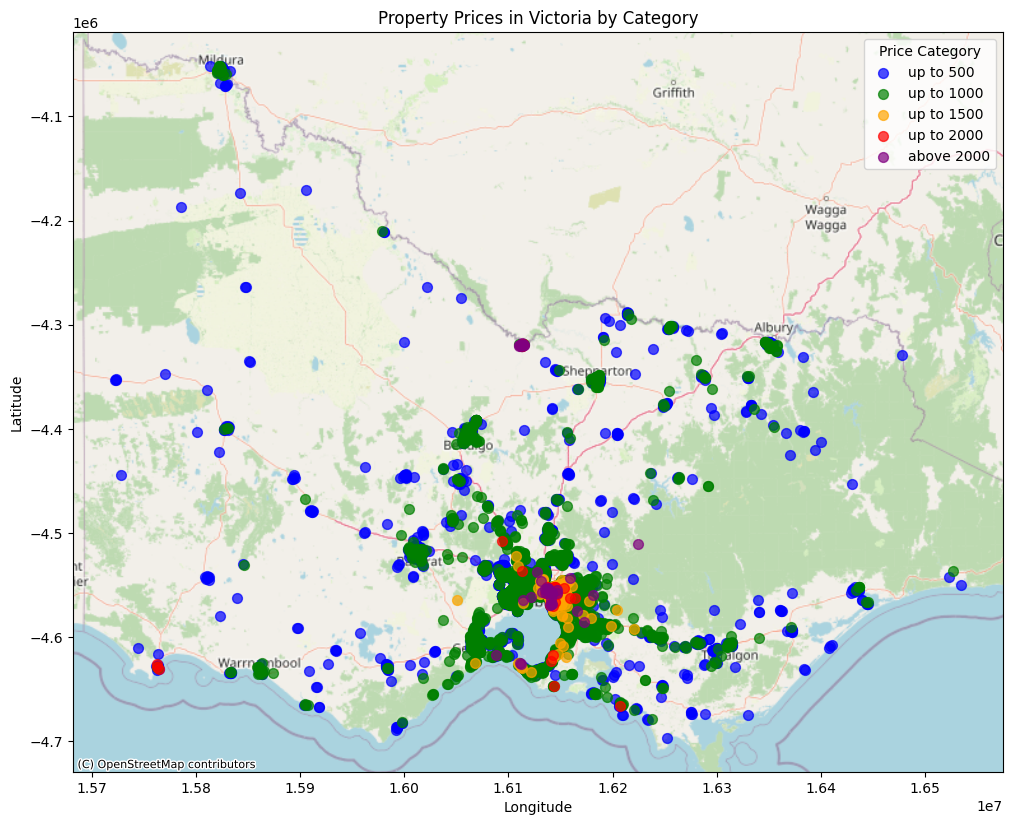

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles
import numpy as np

# Load your data
df = pd.read_parquet('../data/curated/map_features.parquet')

# Ensure 'cost' is numeric
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

# Define price categories
bins = [0, 500, 1000, 1500, 2000, np.inf]  # Define the boundaries for price ranges
labels = ['up to 500', 'up to 1000', 'up to 1500', 'up to 2000', 'above 2000']  # Labels for the price ranges

# Create a new column for price category
df['price_category'] = pd.cut(df['cost'], bins=bins, labels=labels, include_lowest=True)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

# Define a color map for price categories
cmap = {
    'up to 500': 'blue',
    'up to 1000': 'green',
    'up to 1500': 'orange',
    'up to 2000': 'red',
    'above 2000': 'purple'
}

# Plot the categorized data
fig, ax = plt.subplots(figsize=(12, 10))

# Loop through each price category and plot with a different color
for category, color in cmap.items():
    gdf[gdf['price_category'] == category].plot(
        ax=ax, 
        color=color, 
        markersize=50, 
        label=category, 
        alpha=0.7
    )

# Add OpenStreetMap basemap for geographic context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title, labels, and legend
plt.title('Property Prices in Victoria by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title="Price Category")

# Save the plot to a file
output_image_path = "../data/plots/property_prices_by_category.png"  
plt.savefig(output_image_path, dpi=300)  

plt.show()


/tmp/ipykernel_40850/481212138.py:35: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['price_category'] == price_cat].plot(ax=ax, marker='o', color=color, markersize=5, label=price_cat)


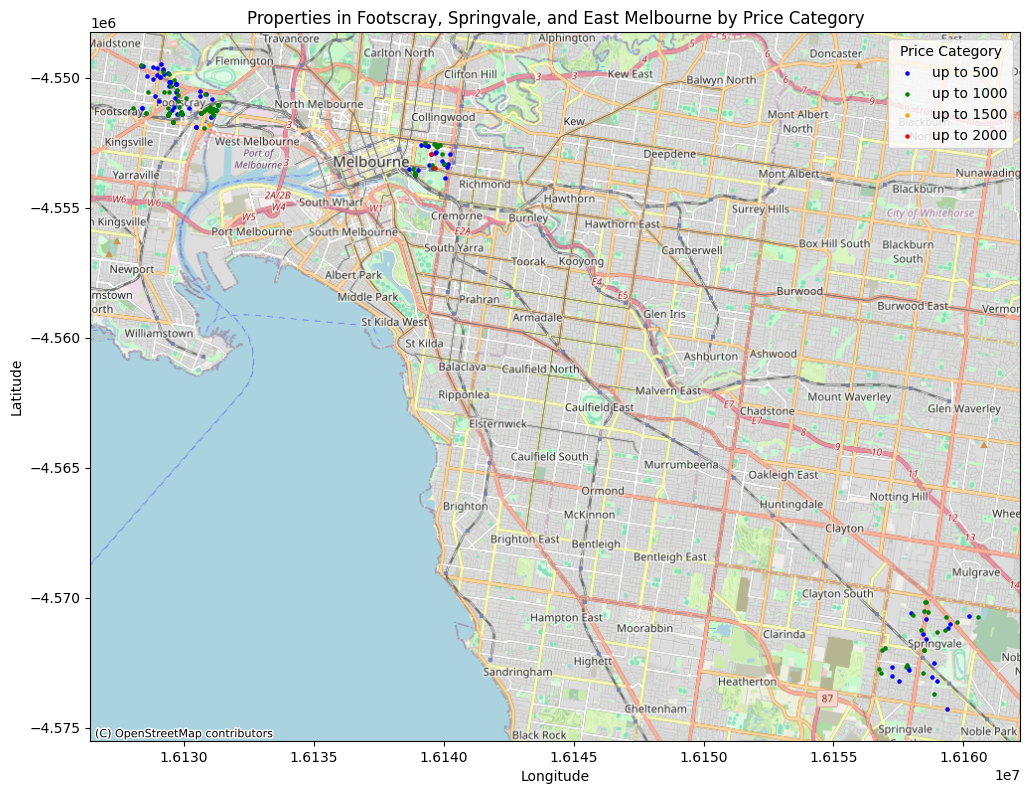

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles


# Extract the suburb name from the 'name' column (which is the last part after 'VIC')
df['suburb'] = df['name'].str.extract(r',\s*([A-Za-z\s]+)\s+VIC')


selected_suburbs = ['Footscray', 'Springvale', 'East Melbourne']


filtered_df = df[df['suburb'].isin(selected_suburbs)]

# Convert the filtered DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

# Plot the map for Footscray, Springvale, and East Melbourne
fig, ax = plt.subplots(figsize=(12, 10))

# Plot properties, using price categories to define colors
price_colors = {
    'up to 500': 'blue',
    'up to 1000': 'green',
    'up to 1500': 'orange',
    'up to 2000': 'red',
    'above 2000': 'purple'
}

for price_cat, color in price_colors.items():
    gdf[gdf['price_category'] == price_cat].plot(ax=ax, marker='o', color=color, markersize=5, label=price_cat)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title, labels, and legend
plt.title('Properties in Footscray, Springvale, and East Melbourne by Price Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title="Price Category")

# Save the plot to a file
#plt.savefig("properties_footscray_springvale_eastmelb.png", dpi=300)

# Display the plot
plt.show()


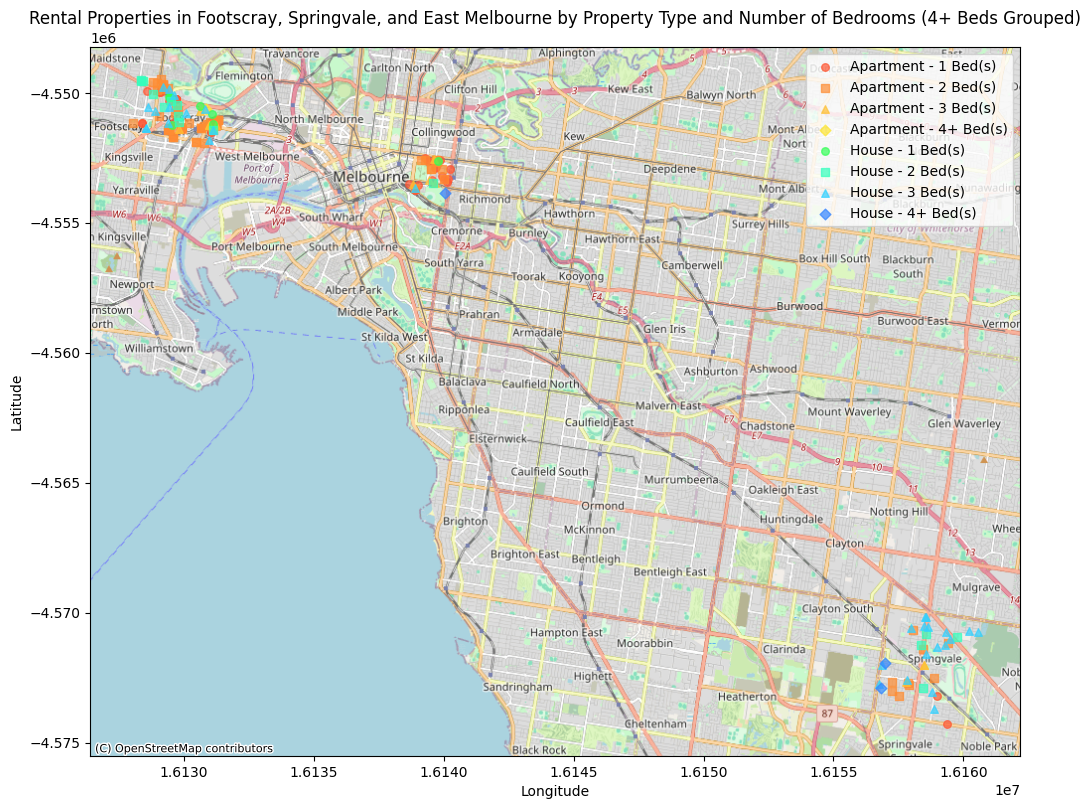

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles
import numpy as np

# Load the properties data (replace with your file)
df = pd.read_parquet('../data/curated/map_features.parquet')

# Convert 'beds' to numeric and filter out properties with 0 beds
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df = df[df['beds'] > 0]  # Remove properties with 0 beds

# Generalize beds to 4+ for bed counts greater than 4
df['beds_grouped'] = df['beds'].apply(lambda x: '4+' if x >= 4 else x)

# Generalize property types into 'Apartments' and 'Houses'
apartment_keywords = ['Apartment', 'New Apartments', 'Flat']
df['property_type_grouped'] = df['property_type'].apply(lambda x: 'Apartment' if any(keyword in x for keyword in apartment_keywords) else 'House')

# Filter the DataFrame for the selected suburbs
selected_suburbs = ['Footscray', 'Springvale', 'East Melbourne']
df['suburb'] = df['name'].str.extract(r',\s*([A-Za-z\s]+)\s+VIC')
df_filtered = df[df['suburb'].isin(selected_suburbs)]

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.longitude, df_filtered.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857), which is required for most web tile services
gdf = gdf.to_crs(epsg=3857)

# Define unique colors for each combination of property type and bed count
color_map = {
    ('Apartment', 1): '#FF5733',  # Red for 1-bed apartments
    ('Apartment', 2): '#FF8D33',  # Orange for 2-bed apartments
    ('Apartment', 3): '#FFC133',  # Yellow for 3-bed apartments
    ('Apartment', '4+'): '#FFE633',  # Light Yellow for 4+ bed apartments
    ('House', 1): '#33FF57',  # Green for 1-bed houses
    ('House', 2): '#33FFBD',  # Cyan for 2-bed houses
    ('House', 3): '#33D1FF',  # Blue for 3-bed houses
    ('House', '4+'): '#3385FF'  # Dark Blue for 4+ bed houses
}

# Create a list of marker symbols for beds
marker_symbols = {1: 'o', 2: 's', 3: '^', '4+': 'D'}

# Plot the properties on the map
fig, ax = plt.subplots(figsize=(12, 10))

# Increase marker size and transparency (alpha) for better visibility
marker_size = 30
alpha_value = 0.7

# Loop through each unique property type and bed group
for (property_type, bed_type), color in color_map.items():
    gdf_filtered = gdf[(gdf['property_type_grouped'] == property_type) & (gdf['beds_grouped'] == bed_type)]
    
    # Only plot if there are properties with the current property type and bed type
    if not gdf_filtered.empty:
        marker_symbol = marker_symbols[bed_type]  # Assign a unique marker for each bed type
        
        gdf_filtered.plot(
            ax=ax,
            marker=marker_symbol,
            color=color,
            markersize=marker_size,
            alpha=alpha_value,  # Add transparency
            label=f"{property_type} - {bed_type} Bed(s)"
        )

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title, labels, and legend
plt.title('Rental Properties in Footscray, Springvale, and East Melbourne by Property Type and Number of Bedrooms (4+ Beds Grouped)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the plot to a file (optional)
plt.savefig("rental_properties_selected_suburbs.png", dpi=300)

# Display the plot
plt.show()
